In [176]:
from scipy.signal import butter, filtfilt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
from pathlib import Path
import os
import neurokit2 as nk
import pywt
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from scipy.stats import entropy, skew, kurtosis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

In [2]:
file_path = Path('C:/Users/vinay/Downloads/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0')
file_name = '100'
file = os.path.join(file_path, file_name)

In [3]:
signal, field = wfdb.rdsamp(file)
annotation = wfdb.rdann(file, 'atr')
print("Annotation Samples:", annotation.sample)
print("Annotation Symbols:", annotation.symbol)

Annotation Samples: [    18     77    370 ... 649484 649734 649991]
Annotation Symbols: ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '

In [4]:
for key in annotation.__dict__.keys():
    if key == 'sample' or key == 'symbol':
        continue
    print(key, annotation.__dict__.get(key))

record_name 100
extension atr
sample [    18     77    370 ... 649484 649734 649991]
subtype [0 0 0 ... 0 0 0]
chan [0 0 0 ... 0 0 0]
num [0 0 0 ... 0 0 0]
aux_note ['(N\x00', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

In [5]:
annotation.sample[:10]

array([  18,   77,  370,  662,  946, 1231, 1515, 1809, 2044, 2402],
      dtype=int64)

In [6]:
unique, counts = np.unique(annotation.symbol, return_counts=True)
print(dict(zip(unique, counts)))

{'+': 1, 'A': 33, 'N': 2239, 'V': 1}


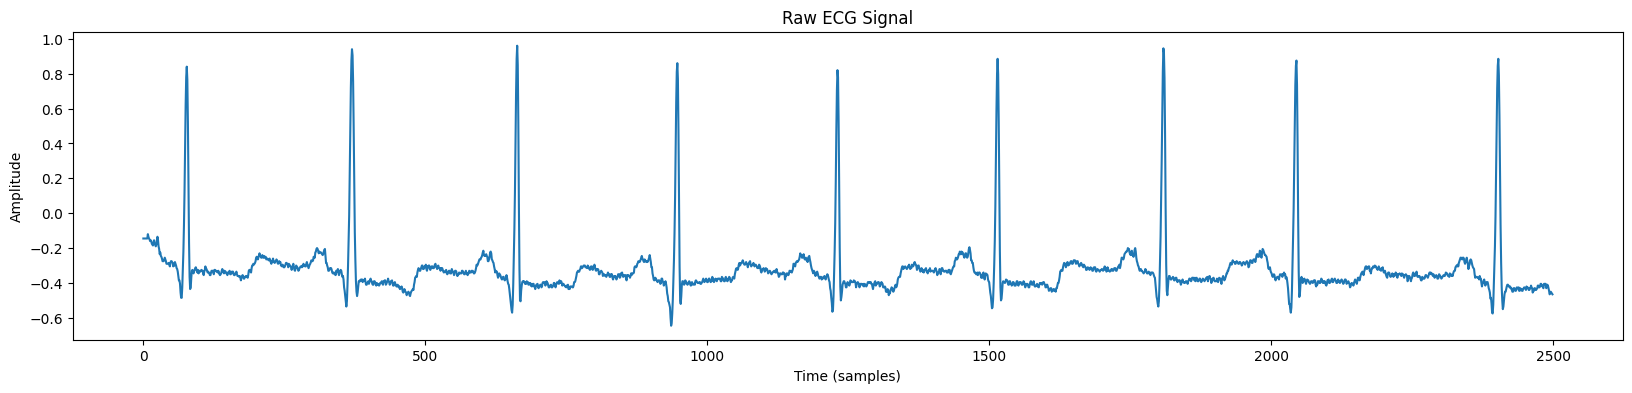

In [185]:
plt.figure(figsize=(20, 4))
plt.plot(signal[:2500, 0])  # Plot the first channel
plt.title('Raw ECG Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

In [8]:
fs = 360
lowcut = 0.5
highcut = 45
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')
filtered_signal = filtfilt(b, a, signal[:, 0])

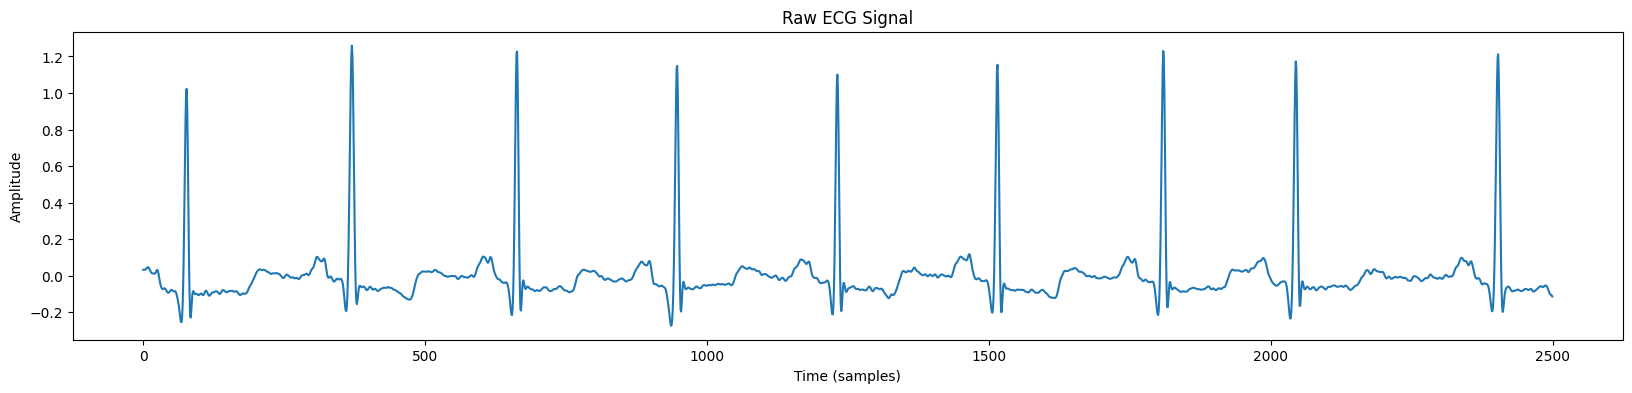

In [9]:
plt.figure(figsize=(20, 4))
plt.plot(filtered_signal[:2500]) 
plt.title('Raw ECG Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

In [67]:
coeffs = pywt.wavedec(filtered_signal, 'db6', level=9)
coeffs[0] = np.zeros_like(coeffs[0])  # Remove cA9 (Baseline Wander)
coeffs[1] = np.zeros_like(coeffs[1])  # Remove cD9 (Low-frequency drift)
coeffs[9] = np.zeros_like(coeffs[9])  # Remove cD1 (High-frequency noise)
coeffs[8] = np.zeros_like(coeffs[8])  # Remove cD2 (High-frequency noise)
coeffs[7] = np.zeros_like(coeffs[7])  # Remove cD3 (High-frequency noise)

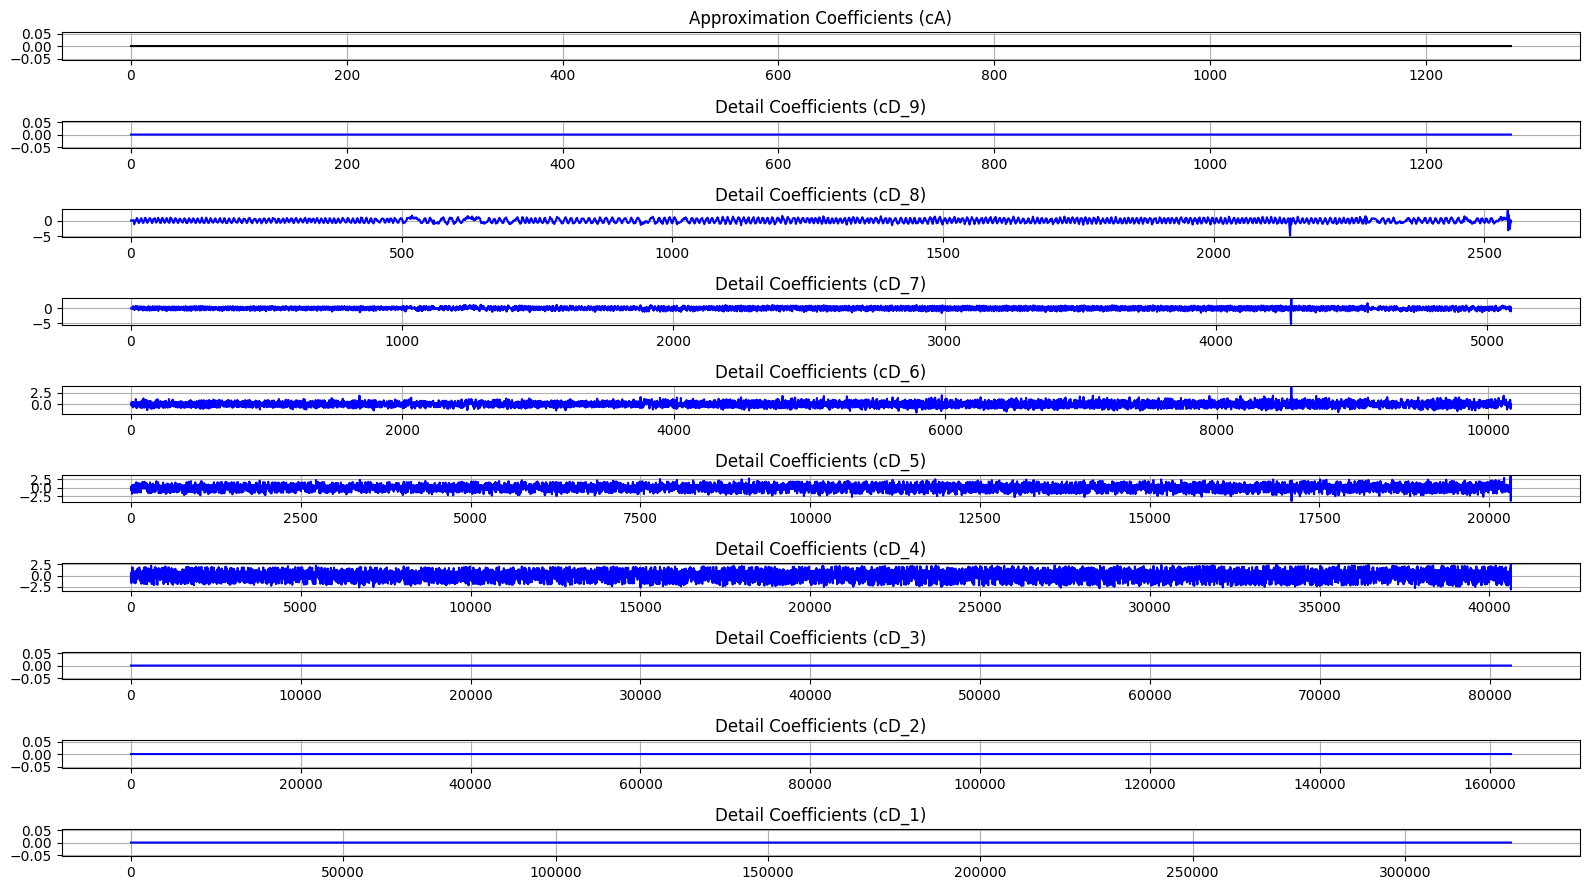

In [68]:
level=9
plt.figure(figsize=(16, 9))

# Approximation coefficients (cA)
plt.subplot(level + 1, 1, 1)
plt.plot(coeffs[0], color='black')
plt.title("Approximation Coefficients (cA)")
plt.grid()

# Detail coefficients (cD)
for i in range(1, level + 1):
    plt.subplot(level + 1, 1, i + 1)
    plt.plot(coeffs[i], color='blue')
    plt.title(f"Detail Coefficients (cD_{level-i+1})")
    plt.grid()

plt.tight_layout()
plt.show()

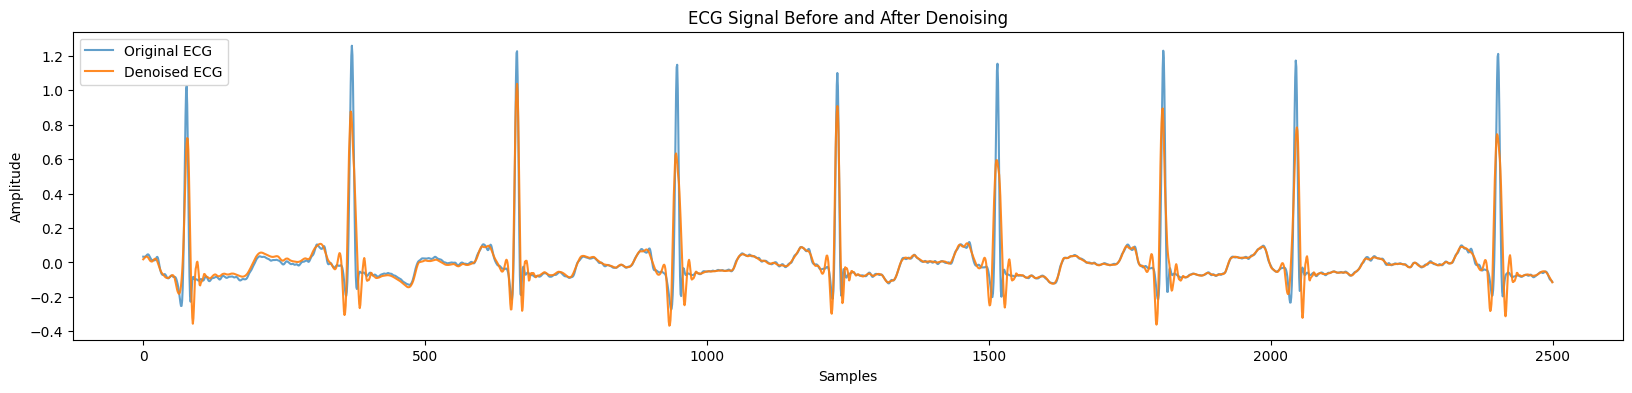

In [69]:
# Reconstruct the denoised signal using inverse wavelet transform
denoised_signal = pywt.waverec(coeffs, 'db6')

# Plot original and denoised signals
plt.figure(figsize=(20, 4))
plt.plot(filtered_signal[:2500], label="Original ECG", alpha=0.7)
plt.plot(denoised_signal[:2500], label="Denoised ECG", alpha=0.9) 
plt.legend()
plt.title("ECG Signal Before and After Denoising")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


In [70]:
signals, info = nk.ecg_process(denoised_signal, sampling_rate=360)
r_peaks = info["ECG_R_Peaks"]

In [78]:
signals

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,0.018124,0.015467,75.507611,0.912634,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,0.021012,0.018464,75.507611,0.912634,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,0.024736,0.021287,75.507611,0.912634,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,0.028566,0.023701,75.507611,0.912634,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,0.031837,0.025477,75.507611,0.912634,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649995,0.976966,0.966471,86.746988,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
649996,0.662809,0.744231,86.746988,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
649997,0.411363,0.508615,86.746988,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
649998,0.207064,0.265773,86.746988,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0


C:\Users\vinay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\neurokit2\ecg\ecg_plot.py:70: NeuroKitWarning: 'info' dict not provided. Some information might be missing. Sampling rate will be set to 1000 Hz.
  warn(


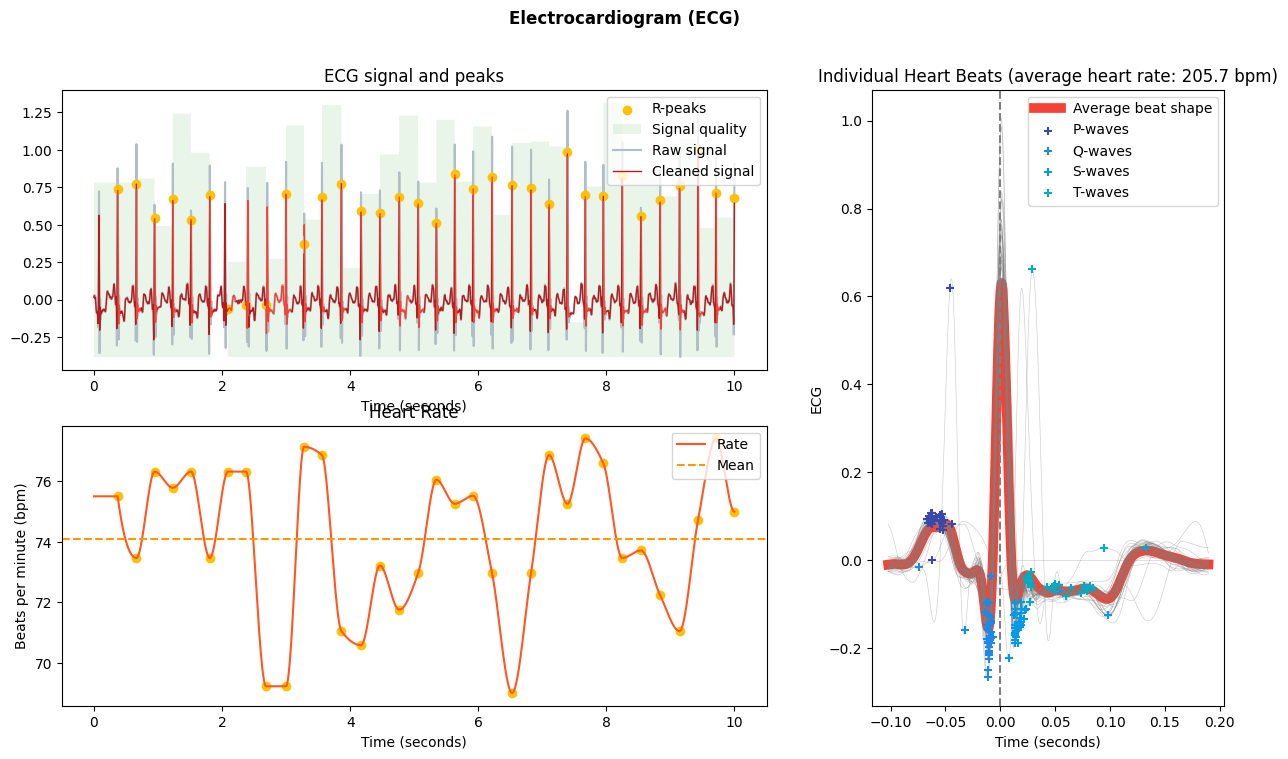

In [71]:
nk.ecg_plot(signals[:10000])
plt.gcf().set_size_inches(15, 8)  # Width: 12 inches, Height: 6 inches
plt.show()

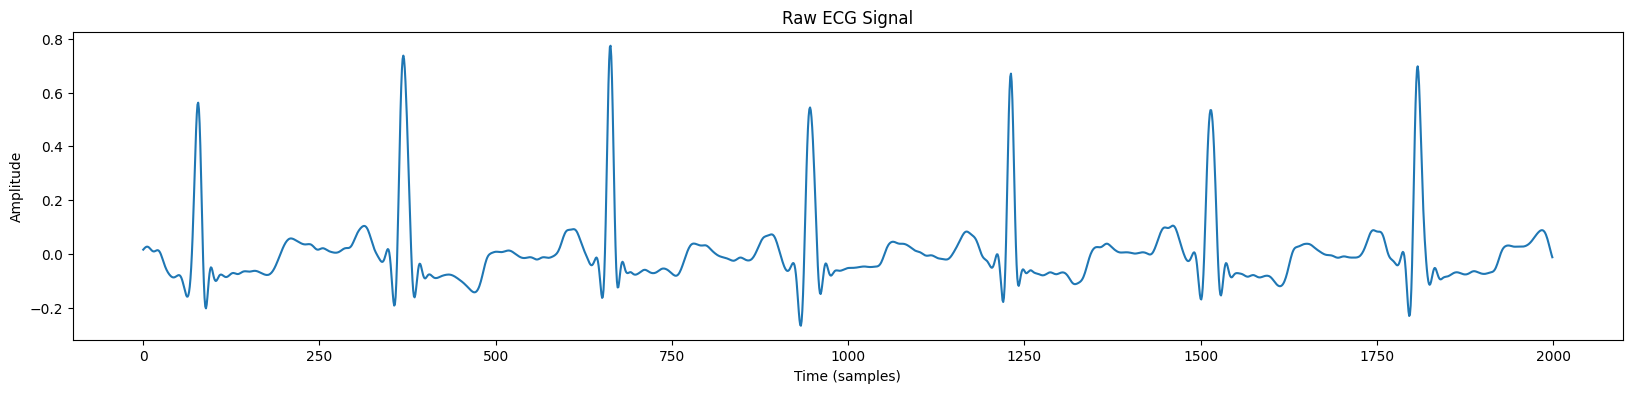

In [72]:
plt.figure(figsize=(20, 4))
plt.plot(signals.ECG_Clean[:2000]) 
plt.title('Raw ECG Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

In [170]:
def compute_rr_features(annotation_samples):
    rr_intervals = np.diff(annotation_samples) / 360  # Compute RR intervals
    
    # Compute individual features
    previous_rr = np.concatenate(([rr_intervals[0]], rr_intervals))  # Shape (2274,)
    post_rr = np.concatenate((rr_intervals, [rr_intervals[-1]]))  # Shape (2274,)
    average_rr = np.full(len(annotation_samples), np.mean(rr_intervals))  # Broadcast single value
    local_rr = np.full(len(annotation_samples), np.mean(rr_intervals[:3]))  # First 3 RR intervals mean
    
    # Stack all RR features into a single NumPy array (2274, 4)
    return np.column_stack((previous_rr, post_rr, average_rr, local_rr))

# Compute RR features
rr_features = compute_rr_features(annotation.sample)

# Verify shape
print(rr_features.shape)  # Expected output: (2274, 4)

(2274, 4)


In [127]:
segmented_signals = [denoised_signal[max(0, peak-50):min(len(denoised_signal), peak+50)] for peak in annotation.sample]

In [172]:
def teager_energy_operator(signal):
    if len(signal) < 100:
        signal = np.pad(signal, (0, 100 - len(signal)), mode='constant')
    teo = signal[1:-1]**2 - signal[:-2] * signal[2:]

    features = [
        np.mean(teo),          
        np.std(teo),           
        np.max(teo),           
        np.min(teo),           
        np.median(teo),        
        np.sum(np.square(teo)),
        entropy(np.abs(teo)),  
        skew(teo),             
        kurtosis(teo),         
    ]
    
    return features  # Return computed feature list

# Compute features for all segments
teager_features = np.array([teager_energy_operator(segment) for segment in segmented_signals])

# Verify shape
print(teager_features.shape)  # Expected output: (2274, 9)

(2274, 9)


In [139]:
def extract_wavelet_features(segmented_signals, wavelet='db4', level=7):
    wavelet_features = []
    
    for segment in segmented_signals:
        # Apply Discrete Wavelet Transform (DWT)
        coeffs = pywt.wavedec(segment, wavelet, level=level)
        
        # Extract the detailed coefficients cD2 to cD7
        # coeffs[1:] contains cD1 to cDn, where cD2 to cD7 are in coeffs[1] to coeffs[6]
        wavelet_details = coeffs[2:7]  # Only cD2 to cD7 (coeffs[1] to coeffs[6])
        
        features = []
        for cD in wavelet_details:
            # Extract features from each detailed coefficient cD2 to cD7
            features.append(np.mean(cD))          # Mean
            features.append(np.std(cD))           # Standard deviation
            features.append(np.max(cD))           # Maximum
            features.append(np.min(cD))           # Minimum
            features.append(np.median(cD))        # Median
            features.append(np.sum(np.square(cD)))  # Energy
            features.append(entropy(np.abs(cD)))  # Entropy
            features.append(skew(cD))             # Skewness
            features.append(kurtosis(cD))         # Kurtosis

        # Append the features for this segment
        wavelet_features.append(features)
    
    return np.array(wavelet_features)

# Example usage
wavelet_features = extract_wavelet_features(segmented_signals)
print(wavelet_features.shape)  # Should be (num_segments, num_features)

C:\Users\vinay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  warnings.warn(


(2274, 45)


In [175]:
all_features = np.hstack((wavelet_features, rr_features, teager_features))  # Shape: (2274, 58)

# Create column names
wave_columns = [f'wave_feature_{i}' for i in range(45)]
rr_columns = ['previous_rr', 'post_rr', 'average_rr', 'local_rr']
teager_columns = [f'teager_feature_{i}' for i in range(9)]

# Create DataFrame
df = pd.DataFrame(all_features, columns=wave_columns + rr_columns + teager_columns)

# Verify shape and content
print(df.shape)  # Expected output: (2274, 58)
print(df.head())

(2274, 58)
   wave_feature_0  wave_feature_1  wave_feature_2  wave_feature_3  \
0       -0.003455        0.085081        0.152359       -0.135384   
1        0.001092        0.441493        0.842566       -0.876365   
2        0.001000        0.650919        1.215722       -1.313383   
3       -0.000778        0.456365        0.849192       -0.917024   
4       -0.000972        0.422395        0.765054       -0.853241   

   wave_feature_4  wave_feature_5  wave_feature_6  wave_feature_7  \
0        0.000740        0.050755        1.407056        0.258320   
1        0.000501        1.559339        1.374570       -0.104223   
2        0.001469        3.389567        1.306294       -0.211148   
3       -0.002024        1.666157        1.303660       -0.178750   
4       -0.014530        1.427347        1.336616       -0.244386   

   wave_feature_8  wave_feature_9  ...  local_rr  teager_feature_0  \
0       -0.439587       -0.000784  ...  0.596296          0.000282   
1        0.609637  

In [180]:
df = df.drop(0).reset_index(drop=True)

In [181]:
df.to_excel('ECG_Feature_Engineering.xlsx', index=False)

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.92      0.96        12
           N       1.00      1.00      1.00       557

    accuracy                           1.00       569
   macro avg       1.00      0.96      0.98       569
weighted avg       1.00      1.00      1.00       569



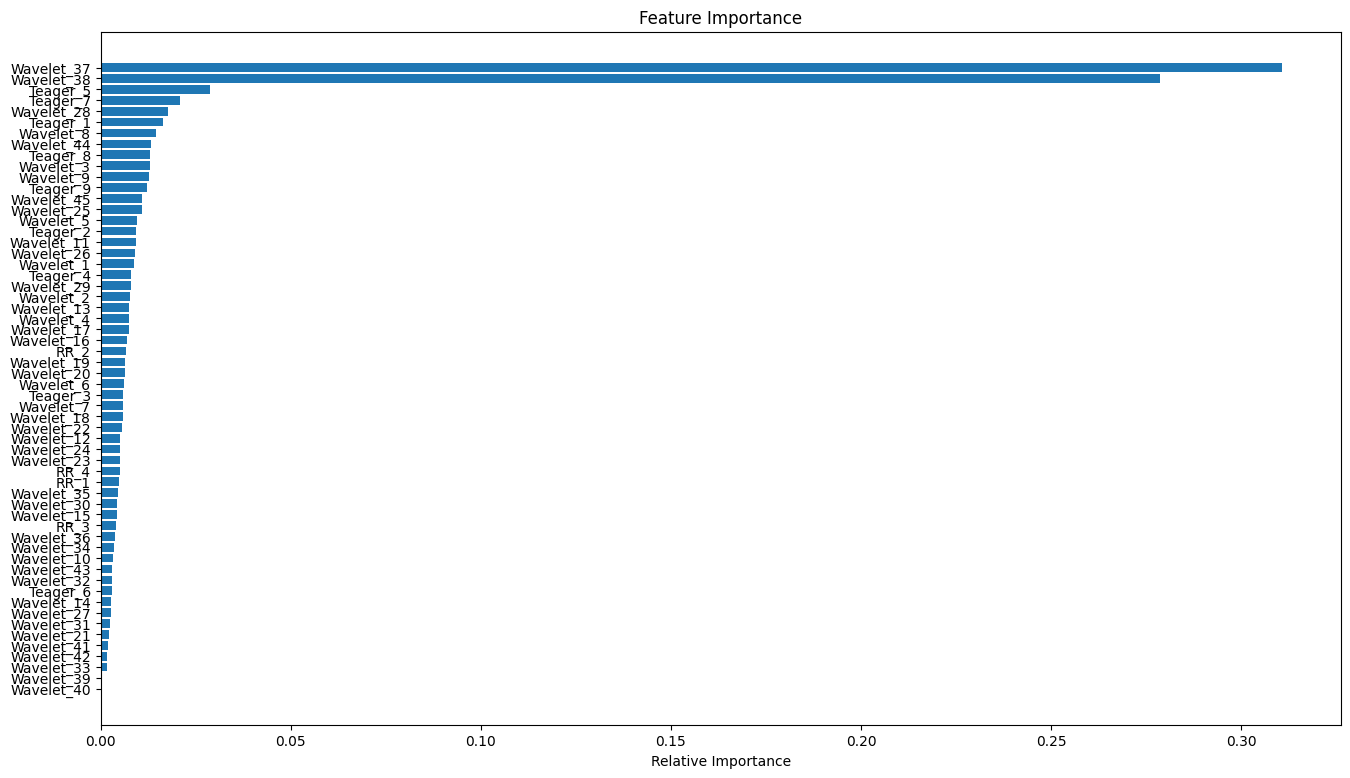

In [183]:
# Assuming your features are in `X` and your labels are in `y`
# X: The feature matrix with 58 features per sample
# y: The target labels (e.g., arrhythmic vs normal)

# Step 1: Normalize the data (Optional, but often improves performance)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)  # Normalize the feature matrix

# Step 2: Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df_scaled, annotation.symbol, test_size=0.25, random_state=42)

# Step 3: Create the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 4: Train the model
rf_model.fit(X_train, y_train)

# Step 5: Predict on the test set
y_pred = rf_model.predict(X_test)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 7: Visualize feature importance
feature_importances = rf_model.feature_importances_
features = ['Teager_' + str(i) for i in range(1, 10)] + ['Wavelet_' + str(i) for i in range(1, 46)] + ['RR_' + str(i) for i in range(1, 5)]
indices = np.argsort(feature_importances)

plt.figure(figsize=(16, 9))
plt.title("Feature Importance")
plt.barh(range(len(indices)), feature_importances[indices], align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()